# **Naive models vs. neural networks in forecasting**

Naive models of time series (e.g., see [here](https://otexts.com/fpp2/simple-methods.html)) provide useful benchmarks to judge the test set performance of autoregressive models. They help reveal the actual gain of using more complex model types/architectures, and do so by showing how good a deliberately simple model would be if used on the available data. 

The logic behind this is: if a very simple model does only slightly worse than a more sophisticated one, the latter is probably not justified. For example, if a naive model as simple as $x(t) = x(t-1)$ has a test set error that's only, say, 5% worse than that of a neural network with hundreds or thousands of parameters, there's really no reason to incur the cost of that complexity, i.e., our modelling approach would not be _**parsimonious**_ (apart from the obvious overfitting risk). 

What's more interesting is that, in practice, it's often the case that naive models perform surprisingly well compared to more complex approaches, especially in data-limited contexts. In such situations, any neural networks (LSTMs, convolutional models) we train can have but a few parameters/layers in order to avoid overfitting, and with such parameter- and data-limitations these architectures cannot realize their potential, limiting any gains in performance afforded by their complexity.  

This notebook illustrates this situation with synthetic data.

In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from utils import (
    split_and_standarize_data,
    WindowGenerator, compile_and_fit, make_ypred
)

Let's start by building two synthetic datasets based on an seasonal autoregressive process - a small one, with just a couple of thousand datapoints, and a big dataset with >100k observations

In [41]:
def make_autoregressive_series(n, sigma, phi1):

    sigma = sigma # variance of noise term
    delta = 0. # drift
    phi1 = phi1 # 1st-order autoregression coefficient
    w = np.random.normal(loc=0, scale=2, size=n) # noise vector
    t = np.arange(n) # time vector
    x = np.zeros(n, float) # initialize series
    T1, T2, T3 = 100000, 5000, 500 # periods of seasonal components
    s1, s2, s3 = np.sin(2.*np.pi/T1*t), np.sin(2.*np.pi/T2*t), np.sin(2*np.pi/T3*t)
    x[0] = 0.0 # first value of series

    # build series
    for i in range(1, n, 1):
        x[i] = delta + phi1*x[i-1] + + s1[i] + s2[i] + s3[i] + w[i]
    
    x = pd.DataFrame(x, index=t, columns=['x'])

    return x

train: (2400, 1)
val: (800, 1)
test: (800, 1)


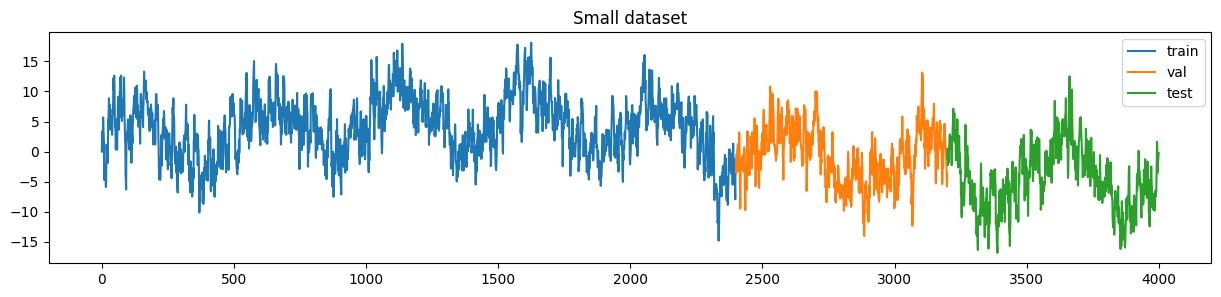

In [42]:
x_small = make_autoregressive_series(n=4000, sigma=3, phi1=0.8)

x_small_datasets = split_and_standarize_data(x_small, f_train=0.6, f_val=0.2)

fig = plt.figure(figsize=(15, 3))
gs = gridspec.GridSpec(1, 1)
ax = fig.add_subplot(gs[:,:])
ax.plot(x_small_datasets['train_timestamps'], x_small_datasets['train_df_original']['x'], label='train')
ax.plot(x_small_datasets['val_timestamps'], x_small_datasets['val_df_original']['x'], label='val')
ax.plot(x_small_datasets['test_timestamps'], x_small_datasets['test_df_original']['x'], label='test')
ax.legend()
ax.set_title('Small dataset')
plt.show()

train: (150000, 1)
val: (50000, 1)
test: (50000, 1)


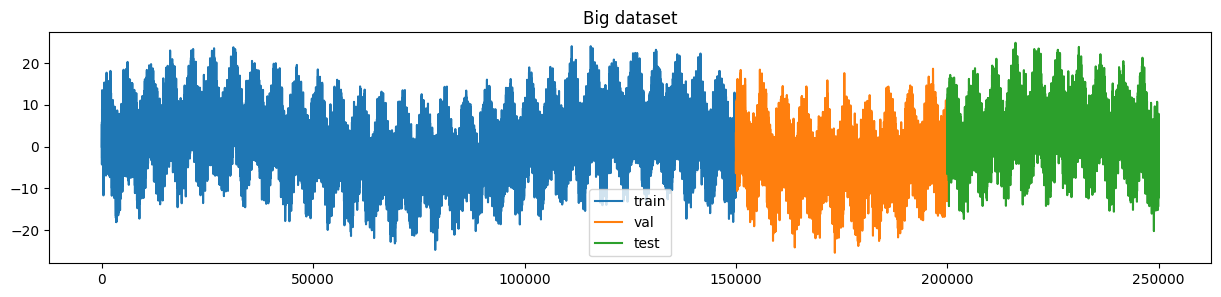

In [43]:
x_big = make_autoregressive_series(n=250000, sigma=2, phi1=0.8)

x_big_datasets = split_and_standarize_data(x_big, f_train=0.6, f_val=0.2)

fig = plt.figure(figsize=(15, 3))
gs = gridspec.GridSpec(1, 1)
ax = fig.add_subplot(gs[:,:])
ax.plot(x_big_datasets['train_timestamps'], x_big_datasets['train_df_original']['x'], label='train')
ax.plot(x_big_datasets['val_timestamps'], x_big_datasets['val_df_original']['x'], label='val')
ax.plot(x_big_datasets['test_timestamps'], x_big_datasets['test_df_original']['x'], label='test')
ax.legend()
ax.set_title('Big dataset')
plt.show()

Now, define a Conv1D model with the followind `BATCH_SIZE`, `MAX_EPOCHS` and window parameters:
- `CONV_WIDTH`: No. observations used in the convolution, i.e., `kernel_size` for ` tf.keras.layers.Conv1D()`
- `LABEL_WIDTH`: No. observations to be predicted, 1 in this case (single-step prediction, although multi-step outputs are easily accomodated with neural networks)
- `INPUT_WIDTH`: No. observations used as input in the autoregression, i.e., how many datapoints from the past are used to predict the label. `INPUT_WIDTH` must be `LABEL_WIDTH` + (`CONV_WIDTH` - 1) because our `tf.keras.layers.Conv1D` layer uses no padding (i.e., default padding = `valid`), and this means the output is `kernel_size` - 1 steps shorter than the input. Hence, if we want, for instance, `LABEL_WIDTH` = 1 and `kernel_size` (= `CONV_WIDTH`) = 10, we need `INPUT_WIDTH` = 1 + (10 - 1) = 10. Another example: if we wanted `LABEL_WIDTH` = 3 and are using `kernel_size` (= `CONV_WIDTH`) = 5, we'd need `INPUT_WIDTH` = 3 + (5 - 1) = 7. Otherwise the lengths of the predicted and label sequences wouldn't match

In [60]:
BATCH_SIZE = 32
MAX_EPOCHS = 100
CONV_WIDTH = 5
LABEL_WIDTH = 1
INPUT_WIDTH = LABEL_WIDTH + (CONV_WIDTH - 1)

conv_small = tf.keras.Sequential([
    tf.keras.layers.Conv1D(filters=1, kernel_size=(CONV_WIDTH,)),
    tf.keras.layers.Dense(units=1),
])

w_conv_small = WindowGenerator(
    input_width=INPUT_WIDTH, 
    label_width=LABEL_WIDTH, 
    offset=1, 
    train_df=x_small_datasets['train_df'],
    val_df=x_small_datasets['val_df'],
    test_df=x_small_datasets['test_df'],
    batch_size=BATCH_SIZE,
    label_columns=['x'])

print(f'X shape = {w_conv_small.example[0].shape}')
print(f'y_pred shape = {conv_small(w_conv_small.example[0]).shape}')
print(f'y_obs shape = {w_conv_small.example[1].shape}')

conv_small(w_conv_small.example[0]) # build model to get number of parameters

print(f'Estimating {conv_small.count_params():,} parameters on {w_conv_small.train_df.shape[0]:,} datapoints')

X shape = (32, 5, 1)
y_pred shape = (32, 1, 1)
y_obs shape = (32, 1, 1)
Estimating 8 parameters on 2,400 datapoints


In [61]:
history_conv_small = compile_and_fit(conv_small, w_conv_small, max_epochs=MAX_EPOCHS, patience=20, verbose=1)

Epoch 1/100
75/75 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 2.7680 - mean_absolute_error: 1.3422 - val_loss: 4.1601 - val_mean_absolute_error: 1.6870
Epoch 2/100
75/75 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 2.0273 - mean_absolute_error: 1.1536 - val_loss: 3.1956 - val_mean_absolute_error: 1.4781
Epoch 3/100
75/75 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 1.6202 - mean_absolute_error: 1.0316 - val_loss: 2.5678 - val_mean_absolute_error: 1.3228
Epoch 4/100
75/75 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 1.3108 - mean_absolute_error: 0.9253 - val_loss: 2.1466 - val_mean_absolute_error: 1.2077
Epoch 5/100
75/75 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 1.1271 - mean_absolute_error: 0.8604 - val_loss: 1.8257 - val_mean_absolute_error: 1.1121
Epoch 6/100
75/75 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.9930 - mean_absolute_error: 0.8066 - val_loss: 1.5622 - val_mean_absolute_error: 1.0269
Epoch 7/100
75/75 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.8618 - mean_absolute_error: 0.7486 - val_loss

In [62]:
ypred_conv_small = make_ypred(conv_small, w_conv_small, x_small_datasets['train_mean']['x'], x_small_datasets['train_sd']['x'])

25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step


...and a large model to be trained on the large dataset...

In [68]:
BATCH_SIZE = 32
MAX_EPOCHS = 100
CONV_WIDTH = 5
LABEL_WIDTH = 1
INPUT_WIDTH = LABEL_WIDTH + (CONV_WIDTH - 1)

conv_big = tf.keras.Sequential([
    tf.keras.layers.Conv1D(filters=20, kernel_size=(CONV_WIDTH // 2,)),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(20, activation='relu'),
    tf.keras.layers.Dense(units=1),
    tf.keras.layers.Reshape([1, 1])
])

w_conv_big = WindowGenerator(
    input_width=INPUT_WIDTH, 
    label_width=LABEL_WIDTH, 
    offset=1, 
    train_df=x_big_datasets['train_df'],
    val_df=x_big_datasets['val_df'],
    test_df=x_big_datasets['test_df'],
    batch_size=BATCH_SIZE,
    label_columns=['x'])

print(f'X shape = {w_conv_big.example[0].shape}')
print(f'y_pred shape = {conv_big(w_conv_big.example[0]).shape}')
print(f'y_obs shape = {w_conv_big.example[1].shape}')

conv_big(w_conv_big.example[0]) # build model to get number of parameters

print(f'Estimating {conv_big.count_params():,} parameters on {w_conv_big.train_df.shape[0]:,} datapoints')

X shape = (32, 5, 1)
y_pred shape = (32, 1, 1)
y_obs shape = (32, 1, 1)
Estimating 1,701 parameters on 150,000 datapoints


In [69]:
history_conv_big = compile_and_fit(conv_big, w_conv_big, max_epochs=MAX_EPOCHS, patience=5, verbose=1)

Epoch 1/100
4688/4688 ━━━━━━━━━━━━━━━━━━━━ 28s 6ms/step - loss: 0.1067 - mean_absolute_error: 0.2538 - val_loss: 0.0936 - val_mean_absolute_error: 0.2443
Epoch 2/100
4688/4688 ━━━━━━━━━━━━━━━━━━━━ 28s 6ms/step - loss: 0.0906 - mean_absolute_error: 0.2406 - val_loss: 0.0933 - val_mean_absolute_error: 0.2439
Epoch 3/100
4688/4688 ━━━━━━━━━━━━━━━━━━━━ 27s 6ms/step - loss: 0.0905 - mean_absolute_error: 0.2405 - val_loss: 0.0918 - val_mean_absolute_error: 0.2419
Epoch 4/100
4688/4688 ━━━━━━━━━━━━━━━━━━━━ 25s 5ms/step - loss: 0.0904 - mean_absolute_error: 0.2403 - val_loss: 0.0912 - val_mean_absolute_error: 0.2412
Epoch 5/100
4688/4688 ━━━━━━━━━━━━━━━━━━━━ 24s 5ms/step - loss: 0.0903 - mean_absolute_error: 0.2401 - val_loss: 0.0919 - val_mean_absolute_error: 0.2421
Epoch 6/100
4688/4688 ━━━━━━━━━━━━━━━━━━━━ 24s 5ms/step - loss: 0.0902 - mean_absolute_error: 0.2399 - val_loss: 0.0908 - val_mean_absolute_error: 0.2406
Epoch 7/100
4688/4688 ━━━━━━━━━━━━━━━━━━━━ 26s 5ms/step - loss: 0.0901 - mea

In [50]:
ypred_conv_big = make_ypred(conv_big, w_conv_big, x_big_datasets['train_mean']['x'], x_big_datasets['train_sd']['x'])

1560/1560 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step


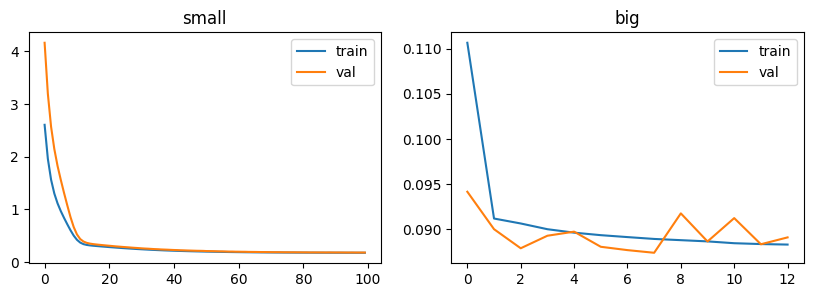

In [63]:
fig, ax = plt.subplots(1, 2, figsize=(10, 3))
ax[0].plot(history_conv_small.history['loss'], label='train')
ax[0].plot(history_conv_small.history['val_loss'], label='val')
ax[0].legend()
ax[0].set_title('small')
ax[1].plot(history_conv_big.history['loss'], label='train')
ax[1].plot(history_conv_big.history['val_loss'], label='val')
ax[1].legend()
ax[1].set_title('big')
plt.show()

Compute errors for the big, large and naive models

In [70]:
ypred = dict()
err_rel = dict()
perc_rel_errors_below_10 = dict()

ypred['conv_big'] = ypred_conv_big
ypred['conv_small'] = ypred_conv_small

err_rel['conv_big'] = 100. * (ypred['conv_big'] - x_big_datasets['test_df_original']['x']) / x_big_datasets['test_df_original']['x']
err_rel['conv_small'] = 100. * (ypred['conv_small'] - x_small_datasets['test_df_original']['x']) / x_small_datasets['test_df_original']['x']

# add ypred and ytest for naive baseline model
ypred_naive_big = x_big_datasets['test_df_original']['x'][:-1].values
ypred_naive_small = x_small_datasets['test_df_original']['x'][:-1].values

ytest_naive_big = x_big_datasets['test_df_original']['x'][1:].values
ytest_naive_small = x_small_datasets['test_df_original']['x'][1:].values

ypred['naive_big'] = ypred_naive_big
ypred['naive_small'] = ypred_naive_small

err_rel['naive_big'] = 100. * (ypred['naive_big'] - ytest_naive_big)/ytest_naive_big
err_rel['naive_small'] = 100. * (ypred['naive_small'] - ytest_naive_small)/ytest_naive_small

perc_rel_errors_below_10['conv_big'] = 100.*err_rel['conv_big'][err_rel['conv_big'] <= 10].size/err_rel['conv_big'].size
perc_rel_errors_below_10['naive_big'] = 100.*err_rel['naive_big'][err_rel['naive_big'] <= 10].size/err_rel['naive_big'].size

perc_rel_errors_below_10['conv_small'] = 100.*err_rel['conv_small'][err_rel['conv_small'] <= 10].size/err_rel['conv_small'].size
perc_rel_errors_below_10['naive_small'] = 100.*err_rel['naive_small'][err_rel['naive_small'] <= 10].size/err_rel['naive_small'].size

print(f"conv big: {perc_rel_errors_below_10['conv_big']:.2f}% with {conv_big.count_params()} params on {w_conv_big.train_df.shape[0]} datapoints, naive big: {perc_rel_errors_below_10['naive_big']:.2f}")
print(f"conv small: {perc_rel_errors_below_10['conv_small']:.2f}% with {conv_small.count_params()} params on {w_conv_small.train_df.shape[0]} datapoints, naive small: {perc_rel_errors_below_10['naive_small']:.2f}")

conv big: 69.75% with 1701 params on 150000 datapoints, naive big: 64.45
conv small: 74.62% with 8 params on 2400 datapoints, naive small: 64.58


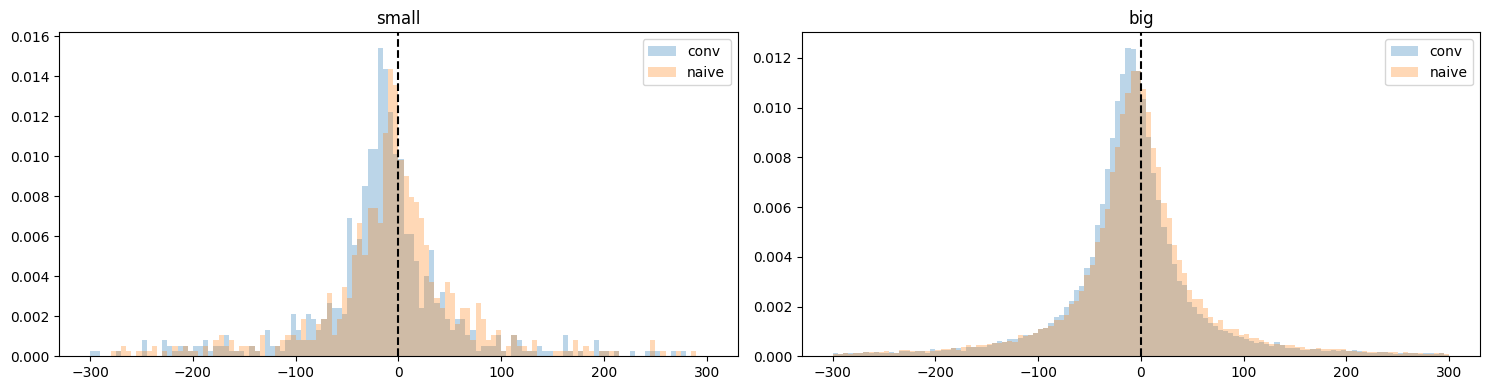

In [54]:
bins = np.arange(-300, 305, 5)
fig = plt.figure(figsize=(15, 4))
gs = gridspec.GridSpec(1, 2)

ax1 = fig.add_subplot(gs[:, 0])
ax1.hist(err_rel['conv_small'], bins=bins, density=True, alpha=0.3, label='conv')
ax1.hist(err_rel['naive_small'], bins=bins, density=True, alpha=0.3, label='naive')
ax1.axvline(x=0, color='black', linestyle='--')
ax1.legend()
ax1.set_title('small')
ax2 = fig.add_subplot(gs[:, 1])
ax2.hist(err_rel['conv_big'], bins=bins, density=True, alpha=0.3, label='conv')
ax2.hist(err_rel['naive_big'], bins=bins, density=True, alpha=0.3, label='naive')
ax2.axvline(x=0, color='black', linestyle='--')
ax2.set_title('big')
ax2.legend()
plt.tight_layout()
plt.show()